In [1]:
import mediapipe as mp
import cv2
import numpy as np
import time

In [2]:
th1 = 10
th2 = 7
blinking_time = 0.4
sampling_period = 1/15
n_smp_blink = round(blinking_time/sampling_period)
print(n_smp_blink)

6


In [4]:
cap = cv2.VideoCapture(2)
face_mesh = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=False,
    min_tracking_confidence=0.5,
    min_detection_confidence=0.5
)

fw = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
fh = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fs = fw, fh
t_vec = []
eye_ratio = []
t0 = time.perf_counter()
i = 0
bv = 0
while True:
    success, frame = cap.read()
    frame = cv2.flip(frame,1)
    frame_rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    if success:
        results = face_mesh.process(frame_rgb)
        mfl = results.multi_face_landmarks
        if mfl:
            all_landmarks = np.array([(lm.x, lm.y) for lm in mfl[0].landmark])
            wl = np.sqrt(((all_landmarks[33]-all_landmarks[133])**2).sum())
            hl1 = np.sqrt(((all_landmarks[159]-all_landmarks[145])**2).sum())
            hl2 = np.sqrt(((all_landmarks[158]-all_landmarks[153])**2).sum())
            hl = (hl1 + hl2) / 2
            
            wr = np.sqrt(((all_landmarks[362]-all_landmarks[263])**2).sum())
            hr1 = np.sqrt(((all_landmarks[385]-all_landmarks[380])**2).sum())
            hr2 = np.sqrt(((all_landmarks[386]-all_landmarks[374])**2).sum())
            hr = (hr1 + hr2) / 2
            
            t_vec.append(round(time.perf_counter() - t0, 3))
            eye_ratio.append((wl / hl + wr / hr) / 2)
            
            if i>=1:
                bv = (eye_ratio[-1]-eye_ratio[-2]) / (t_vec[-1]-t_vec[-2])
#             print((all_landmarks[33]-all_landmarks[133])**2)
#             vec.append(np.abs(all_landmarks-all_landmarks[0]).sum().sum()/all_landmarks.shape[0])
            all_landmarks_pix = np.array(all_landmarks * fs, np.uint32)
            
#             for pix in all_landmarks_pix:
#                 cv2.circle(frame, pix, 2, (0, 0, 255), cv2.FILLED)
#             print(all_landmarks[0].shape)
#             break
#             cv2.circle(frame, int(all_landmarks[0, 0]), int(all_landmarks[0, 1]), 5, (0, 0, 255), cv2.FILLED)
#             print(all_landmarks[0])
            if bv >= th1 or bv <= -th1:
                cv2.imshow("Webcam", frame[:2])
            else:
                cv2.imshow("Webcam", frame)
            q = cv2.waitKey(1)
            if q == ord('q'):
                break
    i += 1

t_vec = np.array(t_vec)
eye_ratio = np.array(eye_ratio)
cv2.destroyAllWindows()
cap.release()

In [5]:
dt = 1 / (t_vec[1:] - t_vec[:-1])
print(dt.mean())
# print(t_vec)

30.706434901829933


In [6]:
eye_ratio_v = eye_ratio.copy()
eye_ratio_v[1:] = (eye_ratio[1:] - eye_ratio[:-1]) / (t_vec[1:] - t_vec[:-1])
eye_ratio_v[0] = eye_ratio_v[1]

In [7]:
import matplotlib.pyplot as plt

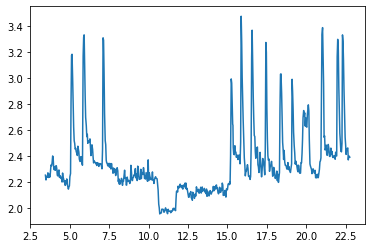

In [8]:
plt.plot(t_vec, eye_ratio)

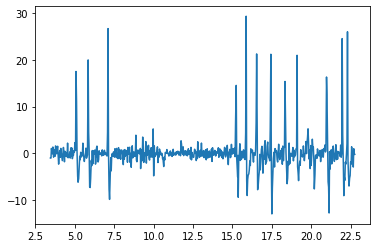

In [9]:
plt.plot(t_vec, eye_ratio_v)

In [10]:
blink_closing = (eye_ratio_v > th1)
blinking = blink_closing.copy()
n_smp = blinking.shape[0]
blink = np.zeros((n_smp,))

befor_closing = round(n_smp_blink / 3) - 1
after_closing = round(2 * n_smp_blink / 3) - 1

for i, bc in enumerate(blink_closing):
    if bc and (i > befor_closing) and (i < n_smp-after_closing):
        for j in range(1, befor_closing+1):
            blinking[i-j] = True
        for j in range(1, after_closing+1):
            blinking[i+j] = True

blink[blinking] = th1

In [61]:
a1 = 2
a2 = 3
print(a1, a2)
del a1, a2

print(a2)

2 3


NameError: name 'a2' is not defined

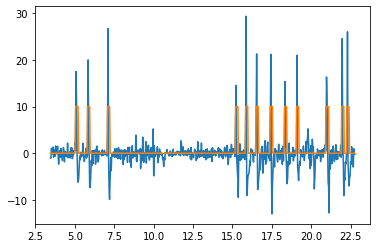

In [11]:
plt.plot(t_vec, eye_ratio_v)
plt.plot(t_vec, blink)